# Content and Objectives

- Show eye diagram for random data
- Spignals are generated and superimpose on intervals of length T

# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 10) )

# Function for determining the impulse response of an RC filter

In [3]:
def get_rc_ir( K, n_sps, t_symbol, beta):  
    ''' 
    Determines coefficients of an RC filter 

    Formula out of: K.-D. Kammeyer, Nachrichtenübertragung
    At poles, l'Hospital was used 

    NOTE: Length of the IR has to be an odd number

    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''

    K = int( K )

    if ( K%2 == 0):
        print('Length of the impulse response should be an odd number')
        sys.exit()

    # initialize np.array    
    rc = np.zeros( K )

    # find sample time and initialize index vector
    t_sample = t_symbol / n_sps
    time_ind = np.linspace( -(K-1)/2, (K-1)/2, K )
    t = t_sample * time_ind
    
    if beta == 0:
        beta = 1e-32

    # assign values of rc
    # if roll-off factor equals 0 use sinc
    for t_i in time_ind:

        t = t_i * t_sample

        if  ( np.abs( np.abs( t ) - np.abs( t_symbol / ( 2 * beta ) ) ) < .001 ):
            rc[int(  t_i + (K-1)/2 )] = np.sin( np.pi * t / t_symbol ) / ( np.pi * t / t_symbol ) * np.pi/4

        elif np.abs(t) < t_sample/20 :
            rc[ int( t_i + (K-1)/2 ) ] = 1

        else:
            rc[ int( t_i + (K-1)/2 ) ] = np.sin( np.pi * t / t_symbol ) / ( np.pi * t / t_symbol ) * \
                np.cos( np.pi * beta * t / t_symbol) / (1- ( 2 * beta * t / t_symbol )**2 ) 


    return rc 

# Parameters

In [4]:
# number of symbols and samples per symbol
n_symb = 1000
n_sps = 8        # samples per symbol

# set time resp. pulse interval and related parameters
t_symb = 1.0 
t_s = t_symb / n_sps                               # sample time

t_min = 0.0
t_max = float(n_symb*t_symb)
t = np.arange(t_min, t_max+t_s, t_s)

t_eye = np.arange(-t_symb/2, t_symb/2+t_s, t_s)

# filter parameters
syms_per_filt = 4  # symbols per filter (plus minus in both directions)    
K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter

# Signals 

In [5]:
# find modulation scheme
M = 2
constellation = np.array( [ -1, 1] )

# generate random binary vector and modulate the specified modulation scheme
d = np.random.randint( M, size=n_symb, dtype=int )
s = constellation[ d ]


###########################
# ideal rc filtering (acausal, infinite,Tx+Rx)
    
# roll-off factor
beta = 0.0

# get rc impulse
rc = get_rc_ir( K_filt, n_sps, t_symb, beta )        

# define extended versions of t and x in order to deal with acausality    # extend time vector in order to deal with filter length
t_extended = np.append( np.append( np.zeros( (K_filt-1)//2 ), t),  np.zeros( (K_filt-1)//2 ))
x_rc_ideal = np.zeros(np.shape(t_extended), dtype=complex)

# loop for symbols and concatenate
for k in range(0, n_symb):
    # put signal at right samples and add them to the whole signal
    pulse = np.zeros(np.shape(t_extended), dtype=complex)            
    pulse[ (k*n_sps) : (k*n_sps + K_filt) ] = rc

    mod_pulse = s[k] * pulse
    x_rc_ideal += mod_pulse

# Plotting

[-0.5, 0.5, -3, 3]

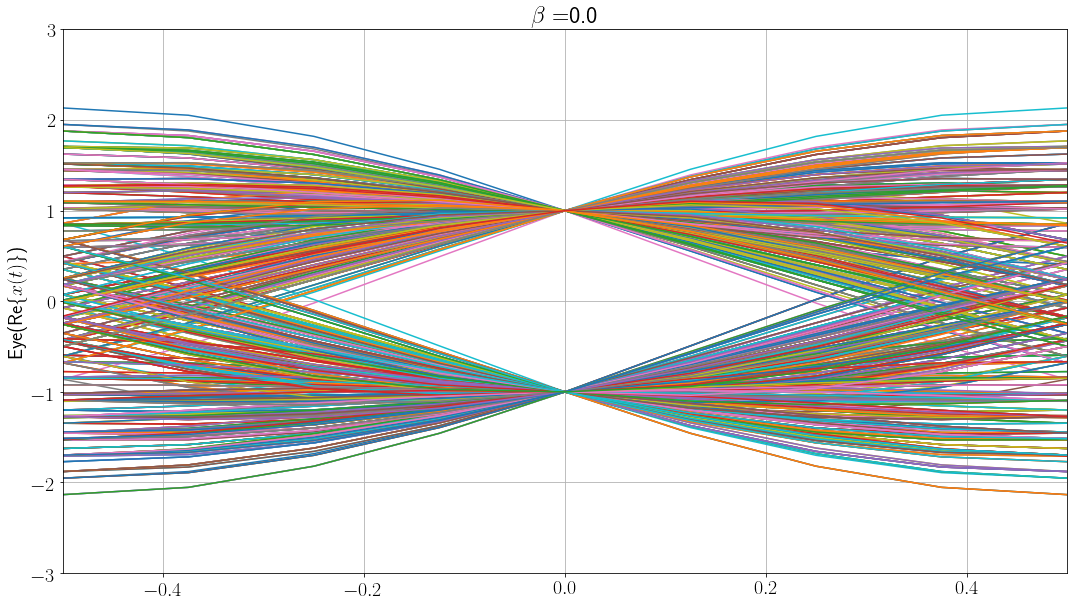

In [6]:
for k in np.arange(3, n_symb-3):
    plt.plot(t_eye, np.real( x_rc_ideal[ k*n_sps+n_sps//2 + (K_filt-1)//2 : (k+1)*n_sps +n_sps//2+(K_filt-1)//2+1] ))

plt.grid(True)
plt.ylabel('Eye(Re\{$x(t)$\})')        
plt.title('$\\beta=$'+str(beta))
plt.axis([-.5, .5, -3, 3])